In [ ]:
import sys, os
from os.path import join, abspath, exists, pardir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import array as a
from astropy.table import Table
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

In [ ]:
train_path = "data/train.csv"
test_path = "data/test.csv"
valid_path = "data/validation.csv"

rng = np.random.default_rng(42)

# Train-Validation Split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import to_categorical
training_data = Table.read(train_path)

classes = np.unique(training_data["class"])
class_d = dict(zip(classes,np.arange(len(classes))))
def class_to_num(c): return class_d[c]
f = np.vectorize(class_to_num)

training_data["class_id"] = f(training_data["class"])

x_train = np.stack([a(training_data[col].astype(float)) for col in ([c for c in training_data.colnames if c not in ["ID","class","class_id"]])]).T

nb_classes = len(classes)

y_train = to_categorical(a(training_data["class_id"]), nb_classes)

# x_train, y_train

In [ ]:
# load validation

valid_data = Table.read(valid_path)
valid_data["class_id"] = f(valid_data["class"])

x_valid = np.stack([a(valid_data[col].astype(float)) for col in ([c for c in valid_data.colnames if c not in ["ID","class","class_id"]])]).T
y_valid = to_categorical(a(valid_data["class_id"]), nb_classes)

In [ ]:
# load testing

test_data = Table.read(test_path)
test_data["class_id"] = f(test_data["class"])

x_test = np.stack([a(test_data[col].astype(float)) for col in ([c for c in test_data.colnames if c not in ["ID","class","class_id"]])]).T
y_test = to_categorical(a(test_data["class_id"]), nb_classes)

In [ ]:
# normalize using the train stats

for c in range(x_train.shape[1]):
    mean, std = np.mean(x_train[:,c]), np.std(x_train[:,c])
    x_train[:,c] = (x_train[:,c]-mean) / std
    x_valid[:,c] = (x_valid[:,c]-mean) / std
    x_test[:,c] = (x_test[:,c]-mean) / std

# Model-building

In [ ]:
es = EarlyStopping(patience=5,monitor="val_loss",mode="min",restore_best_weights=True,verbose=1)

In [ ]:
from tensorflow.keras import metrics
f1_metric = metrics.F1Score(average='weighted')

In [ ]:

inputs = Input(shape=(x_train.shape[1],))

initializer="HeNormal"
dense_activation = LeakyReLU(negative_slope=0.01)

a = 0.5 # dropout rate

neuron_num_1 = 256
neuron_num_2 = 256

regularizer = "L2"
kernel_regularizer=regularizer,

# input MLP
di = Dense(neuron_num_1,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(inputs)
di = Dropout(a)(di)
di = Dense(neuron_num_1,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(di)
di = Dropout(a)(di)
di = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(di)

# residual block
d = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(di)
d = Dropout(a)(d)
d = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(d)
d = Dropout(a)(d)
res = Add()([d,di])

# after residual
d2 = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(res)
d2 = Dropout(a)(d2)
d2 = Dense(neuron_num_2,activation=dense_activation, kernel_regularizer=regularizer, kernel_initializer=initializer)(d2)
d2 = Dropout(a)(d2)

# skip connection
comb = Add()([di,d2])

output = Dense(nb_classes,activation="softmax", kernel_initializer=initializer)(comb)

model = Model(inputs=inputs,outputs=output)
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 256)       │      6,400 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 256)       │          0 │ dense_112[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 256)       │     65,792 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 256)       │          0 │ dense_113[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 256)       │     65,792 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 256)       │     65,792 │ dense_114[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 256)       │          0 │ dense_115[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 256)       │     65,792 │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 256)       │          0 │ dense_116[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 256)       │          0 │ dropout_87[0][0], │
│                     │                   │            │ dense_114[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 256)       │     65,792 │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 256)       │          0 │ dense_117[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 256)       │     65,792 │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 256)       │          0 │ dense_118[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 256)       │          0 │ dense_114[0][0],  │
│                     │                   │            │ dropout_89[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 9)         │      2,313 │ add_29[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,465 (1.54 MB)

 Trainable params: 403,465 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Model(inputs=inputs,outputs=output)
model.compile(loss='categorical_crossentropy', optimizer="ADAM", metrics=['accuracy',f1_metric])
history = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_valid,y_valid), batch_size=32, callbacks=[es])

Epoch 1/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.3113 - f1_score: 0.3063 - loss: 25.5487 - val_accuracy: 0.0504 - val_f1_score: 0.0168 - val_loss: 15.4353
Epoch 2/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.5125 - f1_score: 0.5048 - loss: 2.2433 - val_accuracy: 0.0535 - val_f1_score: 0.0274 - val_loss: 5.2432
Epoch 3/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.5482 - f1_score: 0.5410 - loss: 1.3468 - val_accuracy: 0.0508 - val_f1_score: 0.0158 - val_loss: 4.9537
Epoch 4/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.5582 - f1_score: 0.5505 - loss: 1.3118 - val_accuracy: 0.0423 - val_f1_score: 0.0121 - val_loss: 5.3250
Epoch 5/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.5623 - f1_score: 0.5534 - loss: 1.3005 - val_accuracy: 0.0427 - val_f1_score: 0.0127 - val_loss: 6.9312
Epoch 6/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.5683 - f1_score: 0.5594 - loss: 1.2944 - val_accuracy: 0.0

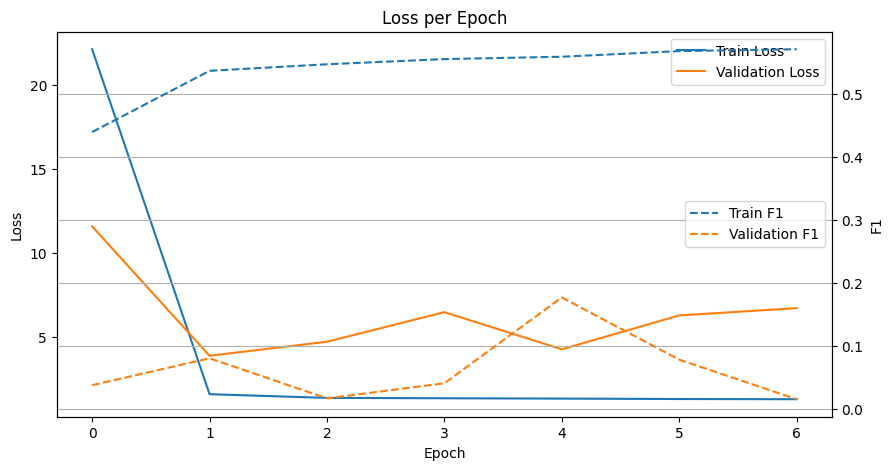

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.plot(train_loss, label='Train Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

train_acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

ax2.plot(train_acc, label='Train F1', linestyle="dashed")
ax2.plot(val_acc, label='Validation F1', linestyle="dashed")
ax2.set_ylabel('F1')
ax2.legend()

plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy, test_f1 = model.evaluate(x_test,y_test)

1154/1154 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4648 - f1_score: 0.3953 - loss: 5.4215


In [ ]:
probas = model.predict(x_test)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(y_test, axis=1)

1154/1154 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [ ]:
print("Accuracy:",accuracy_score(Y_test_dense,preds))
print("Precision:",precision_score(Y_test_dense,preds,average="macro"))
print("Recall:",recall_score(Y_test_dense,preds,average="macro"))
f1 = f1_score(Y_test_dense,preds,average="macro")
print("F1:",f1)

Accuracy: 0.46210090177918595
Precision: 0.1724208526767459
Recall: 0.14263522409058416
F1: 0.1156731358056028


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
id_to_class = dict(zip(np.arange(len(classes)),classes))
def formatter(x, pos):
  return id_to_class[int(x+0.5)-1]

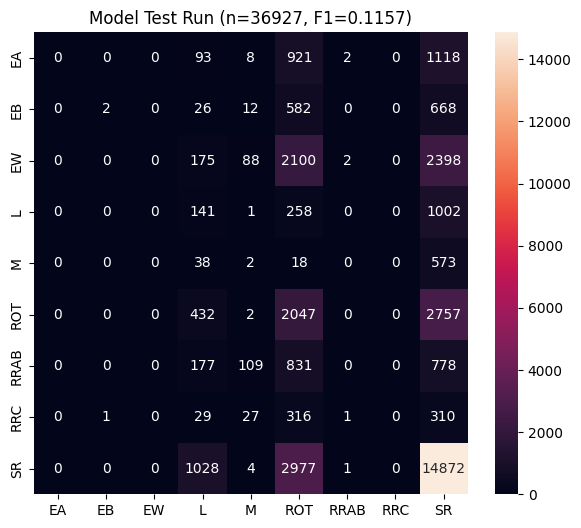

In [ ]:
conf = confusion_matrix(Y_test_dense,preds)
plt.figure(figsize=(7,6))
plt.title(f"Model Test Run (n={len(y_test)}, F1={f1:.4f})")
_=sns.heatmap(conf,annot=True,fmt='d')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig("/content/model_confusion_matrix.png",dpi=300,bbox_inches="tight")